In [27]:
import requests
from functools import cache
import pandas as pd
from ratelimit import limits, sleep_and_retry
from tqdm import tqdm
from functools import partial
from datetime import datetime, timedelta
import pytz
import math
import seaborn as sns
import matplotlib.pyplot as plt

TEAM_ID_FIELD = 'team_id'

def cache_limit_decorator(f):
    return cache(sleep_and_retry(limits(calls=55, period=60)(f)))


class OpenDotaApi:
    ROOT_URL = "https://api.opendota.com/api/"

    @cache
    def prepare_request(self, url):
        return partial(requests.get, f"{self.ROOT_URL}{url}")

    @cache_limit_decorator
    def get_teams(self):
        return requests.get(f"{self.ROOT_URL}teams").json()

    @cache_limit_decorator
    def get_team_players(self, team_id: int):
        return requests.get(f"{self.ROOT_URL}teams/{team_id}/players").json()

    @cache_limit_decorator
    def get_player_info(self, player_id: int):
        data = requests.get(f"{self.ROOT_URL}players/{player_id}").json()
        return {
            "account_id": player_id,
            "rank_tier": data["rank_tier"],
            "solo_mmr": data["mmr_estimate"]["estimate"],
            "leaderboard_rank": data["leaderboard_rank"],
        }

    @cache_limit_decorator
    def get_team_matches(self, team_id: int):
        req = self.prepare_request(f"teams/{team_id}/matches")
        return req().json()


open_doto_api = OpenDotaApi()


In [2]:
def get_leaders_df(refresh=False):
    try:
        if not refresh:
            leaders_df = pd.read_csv('data/leader_teams.csv')
    except FileNotFoundError:
        pass

    teams = open_doto_api.get_teams()
    teams_df = pd.DataFrame.from_dict(teams)
    teams_df["name"] = teams_df["name"].astype('str')
    teams_df["tag"] = teams_df["tag"].astype('str')
    teams_df["name"] = teams_df["name"].apply(lambda s: s.strip())

    leaders_df = teams_df.sort_values(by=["rating"], ascending=False)[:150]
    leaders_df.to_csv('data/leader_teams.csv', index=False)
    return leaders_df

leaders_df = get_leaders_df()

### Collect info about matches

In [3]:
def get_team_matches_df(refresh=False):

    team_matches_df = pd.DataFrame()
    try:
        if not refresh:
            return pd.read_csv("data/team_matches.csv")
    except FileNotFoundError:
        pass

    with tqdm(total=leaders_df.shape[0]) as pbar:
        for index, team in leaders_df.iterrows():
            team_id = team['team_id']
            team_matches = pd.DataFrame(open_doto_api.get_team_matches(team_id))
            team_matches['team_id'] = team_id
            team_matches_df = pd.concat([team_matches_df, team_matches])
            pbar.update(1)

    team_matches_df["won"] = team_matches_df["radiant_win"] == team_matches_df["radiant"]
    team_matches_df.to_csv('data/team_matches.csv', index=False)
    return team_matches_df

team_matches_df = get_team_matches_df()

100%|██████████| 150/150 [02:24<00:00,  1.04it/s]


### Collect info about players

In [4]:
def get_players_df(refresh=False):
    try:
        if not refresh:
            return pd.read_csv('data/team_players.csv')
    except FileNotFoundError:
        pass

    players_df = pd.DataFrame()
    exclude_columns = ["is_current_team_member"]

    for index, leader_team in leaders_df.iterrows():
        team_id = leader_team['team_id']
        players = pd.DataFrame(open_doto_api.get_team_players(team_id))
        players = players[players["is_current_team_member"] == True]
        players["team_name"] = leader_team["name"]
        players["team_rating"] = leader_team["rating"]
        players["team_id"] = team_id
        players = players[[col for col in players.columns if col not in exclude_columns]]
        players_df = pd.concat([players_df, players])

    players_df.to_csv('data/team_players.csv', index=False)

players_df = get_players_df()

In [5]:
def get_player_stats(refresh=False):
    try:
        if not refresh:
            return pd.read_csv('data/player_stats.csv')
    except FileNotFoundError:
        pass

    players_stats_df = pd.DataFrame()

    with tqdm(total=players_df.shape[0]) as pbar:
        for index, player in players_df.iterrows():
            player_info = pd.DataFrame(open_doto_api.get_player_info(player["account_id"]), index=[index])
            player_info.head()
            players_stats_df = pd.concat([players_stats_df, player_info])
            pbar.update(1)

    players_stats_df.to_csv('data/player_stats.csv', index=False)

    return players_stats_df

players_stats_df = get_player_stats()

### Team matches investigation

In [7]:
# Let's filter teams without matches for last half of year
half_year = int((datetime.now() - timedelta(days=182)).timestamp())
active_teams = team_matches_df[["start_time", "team_id"]].groupby("team_id", sort=False).max().reset_index()
active_teams = active_teams[active_teams["start_time"] > half_year]
# active_teams.head(10)
active_leaders_df = leaders_df[leaders_df[TEAM_ID_FIELD].isin(active_teams[TEAM_ID_FIELD])].copy()
", ".join(active_leaders_df["name"])

'Team Spirit, CyberBonch-1, PSG.LGD, Tundra Esports, Royal Never Give Up, BOOM Esports, Team Aster, T1, Virtus.pro, Fnatic, Undying, Team Secret, Evil Geniuses, Polaris Esports, Scenario, OG, OB.Neon, EHOME, Team SMG, Neptune Gaming, Xtreme\xa0 Gaming, Thunder Predator, Team Flamingos, Hellbear Smashers, Team Liquid, Team Tickles, INVICTUS GAMING, Quincy Crew, Nigma Galaxy, CIS Rejects, Entity, Infamous U.esports., Galaxy Racer Esports, CREEPWAVE, Natus Vincere, Ragdoll, Ragdoll, PuckChamp, Infamous Uesports, LBZS, Lilgun, beastcoast, Infinity, 4 Zoomers, Chicken Fighters, Motivate.Trust Gaming'

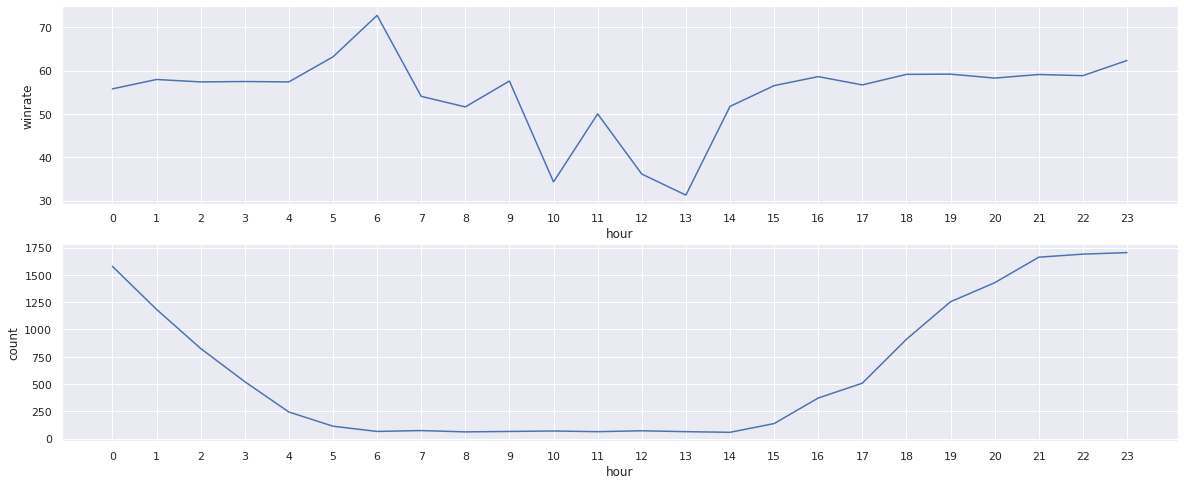

In [44]:
TEAM_NAME_TIMEZONE = {
    "Team Spirit": 'Europe/Moscow',
    "CyberBonch-1": 'Europe/Moscow',
    "PSG.LGD": 'Asia/Shanghai',
    "Tundra Esports": "Europe/Berlin",
    "Royal Never Give Up": 'Asia/Shanghai',
    "BOOM Esports": "Asia/Manila",
    "Team Aster": "Asia/Shanghai",
    "T1": "Asia/Seoul",
    "Virtus.pro": "Europe/Moscow",
    "Fnatic": "Asia/Manila",
    "Undying": "America/Lima",
    "Team Secret": "America/New_York",
    "Evil Geniuses": "US/Central",
   "Polaris Esports" : "Asia/Manila",
   "Scenario": "Asia/Tehran",
   "OG": "Europe/Moscow",
   "OB.Neon": "Asia/Manila",
   "EHOME": "Asia/Shanghai",
    "Team SMG": "Asia/Kuala_Lumpur",
    "Neptune Gaming": "Asia/Shanghai",
    "Xtreme\xa0 Gaming": "Asia/Shanghai",
    "Thunder Predator": "America/Lima",
    "Hellbear Smashers": "Europe/Copenhagen",
    "Team Liquid": "Europe/Stockholm",
    "Team Tickles": "Europe/Copenhagen",
    "INVICTUS GAMING": "Asia/Shanghai",
    "Quincy Crew": "America/New_York",
    "Team Flamingos": "Europe/Moscow",
    "Nigma Galaxy": "Europe/Sofia",
    "CIS Rejects": 'Europe/Moscow',
    "Entity": "Europe/Vienna",
    "Galaxy Racer Esports": "Asia/Kuala_Lumpur",
    "CREEPWAVE": "Europe/Vienna",
    "Natus Vincere": "Europe/Kiev",
    "Ragdoll": "Asia/Kuala_Lumpur",
    "PuckChamp": "Europe/Moscow",
    "Infamous Uesports": "America/Lima",
    "Infamous U.esports.": "America/Lima",
    "LBZS": "Asia/Shanghai",
    "Winstrike Team": "Europe/Moscow",
    "Lilgun": "Asia/Ulaanbaatar",
    "beastcoast": "America/Lima",
    "Infinity": "America/Lima",
    "4 Zoomers": "America/New_York",
    "Chicken Fighters": "Europe/Stockholm",
    "Motivate.Trust Gaming": "Asia/Bangkok",
}

assert all(team_name in TEAM_NAME_TIMEZONE.keys() for team_name in active_leaders_df["name"]), f"Timezone for teams: 'f{[team_name for team_name in active_leaders_df['name'] not in TEAM_NAME_TIMEZONE.keys()]}' is missing!"

year = int((datetime.now() - timedelta(days=365)).timestamp())

active_leaders_df["timezone"] = [TEAM_NAME_TIMEZONE[team_name] for team_name in active_leaders_df["name"]]
actual_team_matches_df = team_matches_df[["team_id", "won", "start_time", "duration"]][team_matches_df["start_time"] > year]
matches_df = actual_team_matches_df[["team_id", "won", "start_time", "duration"]].join(active_leaders_df[["team_id", "name", "timezone"]].set_index("team_id"), on="team_id", how='inner').copy()
matches_df["dt"] = matches_df.aggregate(lambda x: pytz.utc.localize(datetime.fromtimestamp(x["start_time"])).astimezone(pytz.timezone(x["timezone"])), axis=1)
matches_df["hour"] = [dt.hour for dt in matches_df["dt"]]
matches_df = matches_df.sort_values(["dt"], ascending=False)
# matches_df.groupby('name').count().reset_index().sort_values("hour", ascending=False)

wins_and_hours = matches_df[['won', 'hour']].groupby("hour").agg(["count", "sum"])['won'].reset_index()
wins_and_hours["winrate"] = wins_and_hours.aggregate(lambda x: round(100 * x["sum"] / x["count"], 2), axis=1)

f, axs = plt.subplots(2, 1, figsize=(20, 8))
sns.set_theme(style="darkgrid")
frst=sns.lineplot(data=wins_and_hours, x='hour', y='winrate', ax=axs[0]).set_xticks(range(24))
scnd=sns.lineplot(data=wins_and_hours, x='hour', y='count', ax=axs[1]).set_xticks(range(24))

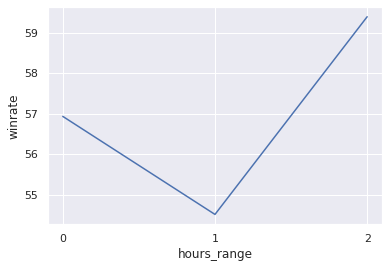

In [73]:
matches_df["hours_range"] = pd.cut(matches_df['hour'], [0,4,17,24], labels=range(3), right=False)
wins_and_hours = matches_df[['won', 'hours_range']].groupby("hours_range").agg(["count", "sum"])['won'].reset_index()
wins_and_hours["winrate"] = wins_and_hours.aggregate(lambda x: round(100 * x["sum"] / x["count"], 2), axis=1)
sns.lineplot(data=wins_and_hours, x='hours_range', y='winrate').set_xticks(range(3))
# wins_and_hours["hours_range"]

### Ranked and winrate

In [ ]:
matches_df = actual_team_matches_df[['team_id', 'won']].join(players_df[["team_id", account_id]].set_index(TEAM_ID_FIELD), how='inner').set_index("account_id").join(players_stats_df[['account_id']])

In [ ]:
df = leaders_df.join(players_df.set_index("team_id"), lsuffix="_team", rsuffix="_player", on="team_id").join(players_stats_df.set_index("account_id"), on="account_id")
df.head(10)

,team_id,rating,wins_team,losses,last_match_time,name_team,tag,logo_url,account_id,name_player,games_played,wins_player,team_name,team_rating,rank_tier,solo_mmr,leaderboard_rank
0,7119388,1550.29,216,173,1642705587,Team Spirit,TSpirit,https://steamusercontent-a.akamaihd.net/ugc/17...,321580662.0,YATOROGOD,223.0,150.0,Team Spirit,1550.29,80,5099.0,15
0,7119388,1550.29,216,173,1642705587,Team Spirit,TSpirit,https://steamusercontent-a.akamaihd.net/ugc/17...,113331514.0,Miposhka,223.0,150.0,Team Spirit,1550.29,80,6139.0,37
0,7119388,1550.29,216,173,1642705587,Team Spirit,TSpirit,https://steamusercontent-a.akamaihd.net/ugc/17...,431770905.0,TORONTOTOKYO,223.0,150.0,Team Spirit,1550.29,80,6139.0,40
0,7119388,1550.29,216,173,1642705587,Team Spirit,TSpirit,https://steamusercontent-a.akamaihd.net/ugc/17...,302214028.0,CoLLapse,223.0,150.0,Team Spirit,1550.29,80,6136.0,43
0,7119388,1550.29,216,173,1642705587,Team Spirit,TSpirit,https://steamusercontent-a.akamaihd.net/ugc/17...,256156323.0,Mira,206.0,140.0,Team Spirit,1550.29,80,6139.0,62
1,7412785,1520.12,267,1,1639928575,CyberBonch-1,CB,https://steamusercontent-a.akamaihd.net/ugc/78...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,1492.85,1480,906,1642945489,PSG.LGD,PSG.LGD,https://steamcdn-a.akamaihd.net/apps/dota2/ima...,898754153.0,萧瑟,394.0,276.0,PSG.LGD,1492.85,80,7649.0,18
2,15,1492.85,1480,906,1642945489,PSG.LGD,PSG.LGD,https://steamcdn-a.akamaihd.net/apps/dota2/ima...,111114687.0,y`,379.0,264.0,PSG.LGD,1492.85,80,7362.0,94
2,15,1492.85,1480,906,1642945489,PSG.LGD,PSG.LGD,https://steamcdn-a.akamaihd.net/apps/dota2/ima...,157475523.0,XinQ,379.0,264.0,PSG.LGD,1492.85,80,7538.0,120
2,15,1492.85,1480,906,1642945489,PSG.LGD,PSG.LGD,https://steamcdn-a.akamaihd.net/apps/dota2/ima...,118134220.0,Faith_bian,379.0,264.0,PSG.LGD,1492.85,80,7351.0,21


In [ ]:
df = df[df["solo_mmr"].notnull()]